## video_5: simple Workflow

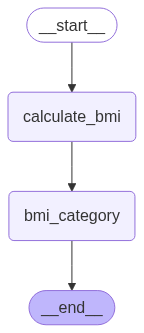

In [2]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END
from typing import TypedDict

# define state schema
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi: float
    category: str


# define bmi node
def calculate_bmi(state: BMIState) -> BMIState:
    """calculates state"""

    weight = state["weight_kg"]
    height = state["height_m"]

    bmi = weight / (height**2)
    state["bmi"] = round(bmi, 2)

    return state

# define category node:
def bmi_category(state: BMIState) -> BMIState:
    """labels bmi category"""

    if state["bmi"] > 10:
        state["category"] = "Unhealthy"

    elif state["bmi"] < 5:
        state["category"] = "Unhealty"

    else:
        state["category"] = "healthy"

    return state


# define stategraph objective
graph = StateGraph(BMIState)


# define nodes
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('bmi_category', bmi_category)

# define edges
graph.add_edge(START, 'calculate_bmi')
graph.add_edge('calculate_bmi', 'bmi_category')
graph.add_edge('bmi_category', END)

# compile graph
workflow = graph.compile()
workflow

In [3]:
input_state: BMIState = {"weight_kg": 80, "height_m": 1.6, "bmi": 0.0, "category": ""}
output_state = workflow.invoke(input_state)
print(output_state)

{'weight_kg': 80, 'height_m': 1.6, 'bmi': 31.25, 'category': 'Unhealthy'}


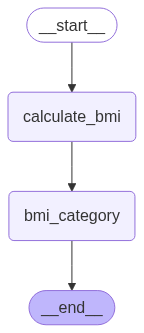

In [4]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

## video_6: Parallel Workflow

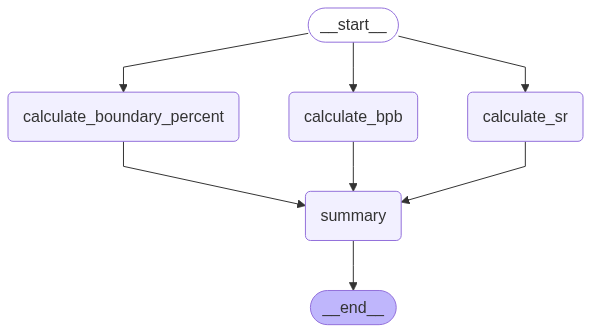

In [ ]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict, Annotated 

# define state schema
class BatsmanState(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int
    sr: float
    bpb: float
    boundary_percent: float
    summary: str

# define calculate_sr method
def calculate_sr(state: BatsmanState):
    sr = (state["runs"] / state["balls"]) * 100
    state["sr"] = sr
    return {"sr": state["sr"]}

# define calculate_bpb method
def calculate_bpb(state: BatsmanState):
    bpb = state["balls"] / (state["fours"] + state["sixes"])
    state["bpb"] = bpb
    return {"bpb": state["bpb"]}

# define calculate_boundary_percent method
def calculate_boundary_percent(state: BatsmanState):
    boundary_percent = ((state["fours"] * 4 + state["sixes"] * 6) / state["runs"]) * 100
    state["boundary_percent"] = boundary_percent
    return {"boundary_percent": state["boundary_percent"]}


# define summary method
def summary(state: BatsmanState) -> BatsmanState:
    summary_var = f"""
                Strike Rate - {state['sr']} \n
                Balls per boundary - {state['bpb']} \n
                Boundary Percent - {state['boundary_percent']} """

    state["summary"] = summary_var
    return state

# define graph
graph = StateGraph(BatsmanState)

# add nodes
graph.add_node("calculate_sr", calculate_sr)
graph.add_node("calculate_bpb", calculate_bpb)
graph.add_node("calculate_boundary_percent", calculate_boundary_percent)
graph.add_node("summary", summary)


# add edges
graph.add_edge(START, "calculate_sr")
graph.add_edge(START, "calculate_bpb")
graph.add_edge(START, "calculate_boundary_percent")

graph.add_edge("calculate_sr", "summary")
graph.add_edge("calculate_bpb", "summary")
graph.add_edge("calculate_boundary_percent", "summary")

graph.add_edge("summary", END)

workflow = graph.compile()
workflow

In [6]:
initial_state: BatsmanState = {
    "runs": 100,
    "balls": 50,
    "fours": 6,
    "sixes": 4,
    "sr": -1,
    "bpb": -1,
    "boundary_percent": -1,
    "summary": "",
}

workflow.invoke(initial_state)

{'runs': 100,
 'balls': 50,
 'fours': 6,
 'sixes': 4,
 'sr': 200.0,
 'bpb': 5.0,
 'boundary_percent': 48.0,
 'summary': '\n                Strike Rate - 200.0 \n\n                Balls per boundary - 5.0 \n\n                Boundary Percent - 48.0 '}

## Video_7 conditional workflow

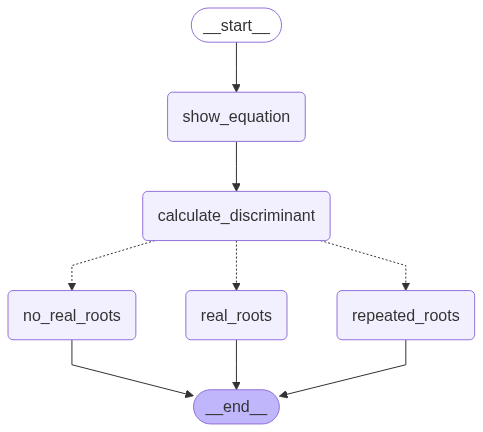

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal

# Create state schema
class QuadState(TypedDict):

    a: int
    b: int
    c: int

    equation: str
    discriminant: float
    result: str


# node methods
def show_equation(state: QuadState):

    equation = f"{state['a']}x2 + {state['b']}x + {state['c']}"
    return {"equation": equation}


def calculate_discriminant(state: QuadState):

    discriminant = state["b"] ** 2 - (4 * state["a"] * state["c"])
    return {"discriminant": discriminant}


def real_roots(state: QuadState):

    root1 = -(state["b"] + state["discriminant"] ** 0.5) / (2 * state["a"])
    root2 = -(state["b"] - state["discriminant"] ** 0.5) / (2 * state["a"])
    result = f"The roots are: {root1} and {root2}"
    return {"result": result}


def repeated_roots(state: QuadState):

    root1 = -(state["b"]) / (2 * state["a"])
    result = f"The only repeating root is: {root1}"
    return {"result": result}


def no_real_roots(state: QuadState):

    result = f"No real roots"
    return {"result": result}

def check_condition(state: QuadState)-> Literal['real_roots', 'repeated_roots', 'no_real_roots']:
    if state['discriminant'] > 0:
        return 'real_roots'
    
    elif state['discriminant'] == 0:
        return 'repeated_roots'
    
    else:
        return 'no_real_roots'


graph = StateGraph(QuadState)


graph.add_node("show_equation", show_equation)
graph.add_node("calculate_discriminant", calculate_discriminant)
graph.add_node("real_roots", real_roots)
graph.add_node("repeated_roots", repeated_roots)
graph.add_node("no_real_roots", no_real_roots)

graph.add_edge(START, 'show_equation')
graph.add_edge("show_equation", "calculate_discriminant")

graph.add_conditional_edges("calculate_discriminant", check_condition)

graph.add_edge("real_roots", END)
graph.add_edge("repeated_roots", END)
graph.add_edge("no_real_roots", END)

workflow = graph.compile()
workflow

In [3]:
initial_state = {"a": 5, "b": 4, "c": 2}

workflow.invoke(initial_state)

{'a': 5,
 'b': 4,
 'c': 2,
 'equation': '5x2 + 4x + 2',
 'discriminant': -24,
 'result': 'No real roots'}

In [4]:
initial_state = {"a": 2, "b": 4, "c": 2}

workflow.invoke(initial_state)

{'a': 2,
 'b': 4,
 'c': 2,
 'equation': '2x2 + 4x + 2',
 'discriminant': 0,
 'result': 'The only repeating root is: -1.0'}

In [5]:
initial_state = {"a": 3455, "b": 644, "c": -2342}

workflow.invoke(initial_state)

{'a': 3455,
 'b': 644,
 'c': -2342,
 'equation': '3455x2 + 644x + -2342',
 'discriminant': 32781176,
 'result': 'The roots are: -0.9217778267681858 and 0.7353812999953927'}

In [8]:
initial_state = {"a": 1, "b": 1, "c": 1}

workflow.invoke(initial_state)

{'a': 1,
 'b': 1,
 'c': 1,
 'equation': '1x2 + 1x + 1',
 'discriminant': -3,
 'result': 'No real roots'}

### llm based conditional

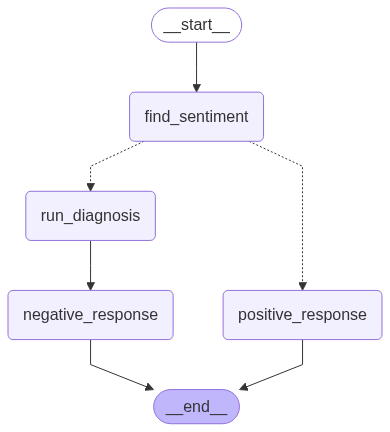

In [9]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict, Literal
from pydantic import BaseModel, Field


# model
model = ChatOllama(model="llama3.2:1b")


# sentiment schema for llm
class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative"] = Field(
        description="sentiment of the review"
    )


# diagnosis schema for llm
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description="The category of issue mentioned in the review"
    )
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(
        description="The emotional tone expressed by the user"
    )
    urgency: Literal["low", "medium", "high"] = Field(
        description="How urgent or critical the issue appears to be"
    )


# review state schema
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str


sentiment_predictor = model.with_structured_output(SentimentSchema)
diagnosis_predictor = model.with_structured_output(DiagnosisSchema)


# node methods
def find_sentiment(state: ReviewState):

    prompt = f"For the following review find out the sentiment \n {state['review']}"
    sentiment = sentiment_predictor.invoke(prompt).sentiment
    return {"sentiment": sentiment}


def check_sentiment(
    state: ReviewState,
) -> Literal["positive_response", "run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"


def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank you message in response to this review:
    \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website. """
    response = model.invoke(prompt).content
    return {"response": response}


def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review: \n\n{state['review']}\n\n
    Return issue_type, tone, and urgency."""
    response = diagnosis_predictor.invoke(prompt)
    return {"diagnosis": response.model_dump()}


def negative_response(state: ReviewState):

    diagnosis = state["diagnosis"]
    prompt = f"""The user had a '{diagnosis['issue_type']}', sounded '{diagnosis['tone']}', and marked urgency '{diagnosis['urgency']}'\n\n
    Write an empathic, helpful resolution message. """
    response = model.invoke(prompt).content
    return {"response": response}

# create graph
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)

# add edges
graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_sentiment)
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)
graph.add_edge("positive_response", END)

workflow = graph.compile()
workflow

In [10]:
initial_state = {"review": "The product was really good!"}

workflow.invoke(initial_state)

{'review': 'The product was really good!',
 'sentiment': 'positive',
 'response': 'Here\'s a potential warm thank-you message:\n\n"Dear [User],\n\nWe\'re so glad to hear that you enjoyed our product! We strive to provide high-quality items that meet our customers\' expectations, and it\'s wonderful to know that we were able to do just that for you.\n\nAs an extra way to show our appreciation, we\'d love it if you could take a moment to leave us a review on our website. Your feedback is invaluable in helping us improve and serve even better customers like you in the future. If you have any other questions or concerns, please don\'t hesitate to reach out.\n\nThanks again for your kind words! We\'re honored to have customers like you."\n\nThis message acknowledges the user\'s positive experience, expresses gratitude, and encourages them to provide feedback, all while maintaining a friendly and professional tone.'}

In [11]:
initial_state = {"review": "The product was really bad!"}

workflow.invoke(initial_state)

{'review': 'The product was really bad!',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'angry',
  'urgency': 'high'},
 'response': 'Here\'s a sample response:\n\n"Hey [User], I\'m here to help you with the \'Performance\' report that was \'angry\'. I understand how frustrating it must be to receive feedback about something that affects your work. Regarding the urgency level, I know it can be overwhelming to prioritize tasks when they\'re due soon. I want to assure you that I\'ve taken a closer look at the data, and while there\'s definitely room for improvement, we can definitely work on prioritizing tasks more effectively moving forward. Let me propose some possible next steps: Can we schedule a follow-up meeting to discuss strategies for tackling this task in a way that gets it done quickly but still meets your quality standards? Additionally, would you be open to adjusting the deadline for this report? I\'m here to support you and help find solutio

## video_8: iterative Workflow

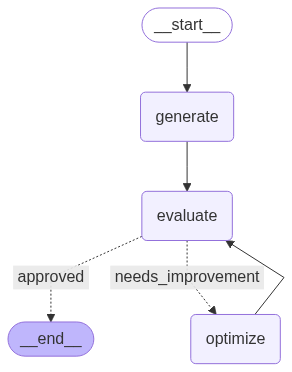

In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
import operator
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field

# create model
llm = ChatOllama(model="llama3.2:1b")


# state schema
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]


# node methods
def generate_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(
            content=f"""
        Write a short, original and hillarious tweet on the topic: {state['topic']}

        Rules:
        - DO NOT USE question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarchasm, or cultural references.
        - Think in meme logic, punchlines or relatable takes.
        - Use simple, day to day english
        - This is version {state['iteration'] + 1}

        """
        ),
    ]

    response = llm.invoke(messages).content
    return {"tweet": response, "tweet_history": [response]}


class EvalSchema(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(
        ..., description="Final evaluation"
    )
    feedback: str = Field(..., description="feedback for the tweet.")


structured_llm = llm.with_structured_output(EvalSchema)


def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(
            content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."
        ),
        HumanMessage(
            content=f"""
            Evaluate the following tweet:
            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality: Is this fresh, or have you seen it a hundred times before?  
            2. Humor: Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness: Is it short, sharp, and scroll-stopping?  
            4. Virality Potential: Would people retweet or share it?  
            5. Format: Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"  
            - feedback: One paragraph explaining the strengths and weaknesses 
            """
        ),
    ]

    response = structured_llm.invoke(messages)

    return {
        "evaluation": response.evaluation,
        "feedback": response.feedback,
        "feedback_history": [response.feedback],
    }


def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(
            content="You punch up tweets for virality and humor based on given feedback."
        ),
        HumanMessage(
            content=f"""
            Improve the tweet based on this feedback:
            "{state['feedback']}"

            Topic: "{state['topic']}"
            Original Tweet:
            {state['tweet']}

            Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
            """
                    ),
                ]

    response = llm.invoke(messages).content
    iteration = state["iteration"] + 1

    return {"tweet": response, "iteration": iteration, "tweet_history": [response]}


def route_evaluation(state: TweetState):
    if (
        state["evaluation"] == "approved"
        or state["iteration"] >= state["max_iteration"]
    ):
        return "approved"

    else:
        return "needs_improvement"


graph = StateGraph(TweetState)

graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimize", optimize_tweet)

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")
graph.add_conditional_edges(
    "evaluate", route_evaluation, {"approved": END, "needs_improvement": "optimize"}
)
graph.add_edge("optimize", "evaluate")

workflow = graph.compile()

workflow

In [13]:
initial_state = {"topic": "Indian Railways", "iteration": 1, "max_iteration": 5}
workflow.invoke(initial_state)

{'topic': 'Indian Railways',
 'tweet': 'Here\'s a rewritten version of the tweet:\n\n"Snack alert: Indian Railways\' food trolley has a secret agenda - to judge our snacks. Delays? Just another reason to be on your best behavior #TrainLife #FoodTrolleysAreTheWorst"\n\nThis revised tweet aims to add originality by incorporating a more unexpected twist (the "secret agenda" of the food trolley), and keeps it concise while still being catchy and memorable.',
 'evaluation': 'approved',
 'feedback': 'The revised tweet is an improvement over the original, but not without its issues. While it adds a fresh twist by incorporating a unexpected secret agenda for the food trolley, the humor remains somewhat predictable. The punchline ',
 'iteration': 3,
 'max_iteration': 5,
 'tweet_history': ['"Indian Railways: because \'delays\' are a thing now. Newsflash: we\'re all just sitting in our trains waiting for the food trolley to finally decide which snack to give us #TrainLife #DelaysAreTheBestPartOfT

In [14]:
initial_state = {"topic": "Indian Railways", "iteration": 1, "max_iteration": 5}
workflow.invoke(initial_state)

{'topic': 'Indian Railways',
 'tweet': '"Indian Railways\' latest \'collapsing\' train story: engineers watching with smug smiles & passengers stuck like lambs to the slaughter! #IndianRailways #TrainWreck"\n\nThis revised tweet maintains a provocative tone, uses hyperbole for attention-grabbing effect, and adds unexpected details (smug smiles) to create a viral-worthy story.',
 'evaluation': 'needs_improvement',
 'feedback': "The tweet attempts to create a provocative narrative by stating that Indian Railways' latest train incident is 'collapsing', using hyperbole for attention-grabbing effect. However, this approach has been seen before and doesn't bring much originality to the table.",
 'iteration': 5,
 'max_iteration': 5,
 'tweet_history': ['"Indian Railways: where a 30-minute delay means you get to enjoy the scenic views of your in-laws\' wedding photos. And by \'scenic\', I mean an Instagram-worthy traffic jam #IndianRailways #TrafficJams"',
  '"30-minute delays = scenic views of

In [15]:
initial_state = {"topic": "Indian Tax system", "iteration": 1, "max_iteration": 5}
workflow.invoke(initial_state)

{'topic': 'Indian Tax system',
 'tweet': 'Here\'s a revised version:\n\n"Married in love or made a deal? Same game here. Indian tax system: where marriage is just a math problem #TaxDrama #IndianFinance"',
 'evaluation': 'needs_improvement',
 'feedback': "The tweet attempts to make a humorous point about Indian tax systems, using the metaphor of marriage as a math problem. While it's not a completely original concept, the comparison does stand out in the Twitter landscape.",
 'iteration': 5,
 'max_iteration': 5,
 'tweet_history': ['"Indian tax system: where \'Section 80C\' means you can save a fortune on your taxes if you\'re married with two kids and own a 5-bedroom mansion. Meanwhile, single people with one child are paying 50% of their salary in \' deductions\'. Mind. Blown."',
  'Here\'s a revised tweet:\n\n"Double taxation alert! In India, married couples get taxed on every income... even if they\'re single at home with zero deductions. Meanwhile, \'Section 80C\' is just a myth th

## video_9: Basic Chatbot

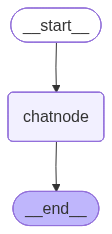

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages] 

# llm
llm = ChatOllama(model='llama3.2:1b')

# node method
def chatnode(state: ChatState):
    messages = state['messages']
    response = llm.invoke(messages)

    return {'messages': [response]}

graph = StateGraph(ChatState)

graph.add_node('chatnode', chatnode)

graph.add_edge(START, 'chatnode')
graph.add_edge('chatnode', END)

workflow = graph.compile()

workflow


In [2]:
# initial_state={'messages':[HumanMessage(content="What is the capital of India")]}
# workflow.invoke(initial_state)['messages'][-1]

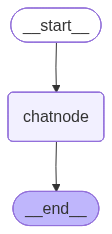

In [3]:
from langgraph.graph import START, StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from typing import TypedDict, Literal

class ChatState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

llm = ChatOllama(model="llama3.2:1b")

# node method
def chat_node(state: ChatState) -> ChatState:
    messages = state['messages']
    response = llm.invoke(messages)

    return {'messages': [response]}

graph = StateGraph(ChatState)

graph.add_node("chatnode", chatnode)
graph.add_edge(START, "chatnode")
graph.add_edge("chatnode", END)

workflow = graph.compile()

workflow

In [4]:
initial_state = {"messages": [HumanMessage(content="What is the capital of India")]}
workflow.invoke(initial_state)["messages"][-1]

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-09-09T13:04:06.7681915Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2284002500, 'load_duration': 2062647600, 'prompt_eval_count': 31, 'prompt_eval_duration': 86263900, 'eval_count': 9, 'eval_duration': 134330200, 'model_name': 'llama3.2:1b'}, id='run--806ace9b-d5d0-4ab6-9f45-3c298165849a-0', usage_metadata={'input_tokens': 31, 'output_tokens': 9, 'total_tokens': 40})

In [5]:
while True:

    user_input = input("type here .. ")
    print(user_input)

    if user_input == 'exit':
        break

    else:
        response = workflow.invoke({
            'messages': [HumanMessage(content=user_input)]
        })

        print(response['messages'][-1].content)

Hi what is 100 + 125
To find the answer, I'll add 100 and 125.

100 + 125 = 225
exit


In [7]:
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict

# model
model = ChatOllama(model="llama3.2:1b")

# schema
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# chatbot methods
def chatnode(state: ChatState):
    message = state['messages']
    response = model.invoke(message)
    return {'messages': [response]}

# chatbot graph
checkpointer = MemorySaver()
graph = StateGraph(ChatState)

graph.add_node('chatnode', chatnode)
graph.add_edge('chatnode', END)
graph.set_entry_point('chatnode')

chatbot = graph.compile(checkpointer=checkpointer)

# chatbot execution
thread_id = '1'

while True:
    user_message = input("Type here ...")
    print(user_message)

    if user_message == "exit":
        break
    else:
        config = {"configurable": {"thread_id": thread_id}}
        response = chatbot.invoke(
            {"messages": [HumanMessage(content=user_message)]}, config=config
        )

        print("AI: ", response["messages"][-1].content)

Hi I am Zishan
AI:  Hello Zishan! How's it going? Is there something on your mind that you'd like to talk about, or are you just looking for some general conversation?
What is my name?
AI:  Your name is Zishan. I'm happy to chat with you and help if I can. It seems we've started our conversation with a question about your identity. Is everything okay? Would you like to talk more about yourself or ask me something in particular?
exit


## video_10: Persistance in langgraph

### uuid

In [ ]:
import uuid

uuid_v1 = uuid.uuid1()
print(uuid_v1)

uuid_v4 = uuid.uuid4()
print(uuid_v4)

c9d5ac6a-8d94-11f0-add4-a8e291d0e275
c68f125a-b7ba-4c4b-a5bc-112bdb4a978f


### persistance

In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:1b")


class JokeState(TypedDict):
    topic: str
    joke: str
    explanation: str


def joke_node(state: JokeState):
    topic = state["topic"]
    prompt = f""" you are a funny person and likes to joke about the given topic. Make a joke about the following topic: {topic}"""
    joke = llm.invoke(prompt).content
    return {"joke": joke}


def explanation_node(state: JokeState):
    joke = state["joke"]
    prompt = f"""You are a boring person and likes to explain everything, even jokes! Explain the following joke: {joke}"""
    explanation = llm.invoke(prompt).content
    return {"explanation": explanation}

graph = StateGraph(JokeState)

graph.add_node("joke_node", joke_node)
graph.add_node("explanation_node", explanation_node)

graph.add_edge(START, "joke_node")
graph.add_edge("joke_node", "explanation_node")
graph.add_edge("explanation_node", END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

# config1
config1 = {"configurable": {"thread_id": "1"}}
initial_state = {"topic": "Indian Politics"}
response = workflow.invoke(initial_state, config=config1)
print(response)

# config2
config2 = {"configurable": {"thread_id": "2"}}
initial_state = {"topic": "Wheather in Germany"}
response = workflow.invoke(initial_state, config=config2)
print(response)

{'topic': 'Indian Politics', 'joke': 'Indian politics, where the only thing more confusing than the policies is the number of politicians you can find with that name! I mean, who needs a degree in economics when you\'ve got a master\'s in "Make India Great Again"?', 'explanation': 'My friend, let me tell you, this joke is a masterpiece of complexity. You see, it\'s not just about the number of politicians with that name, although, as you mentioned, it\'s certainly a staggering figure. No, no, what\'s truly fascinating here is the layer upon layer of confusion and absurdity that comes with navigating Indian politics.\n\nFirstly, let\'s start with the obvious: there are over 1,000 members of Parliament in India, and each one has a unique name. But what happens when you want to learn about their policies? That\'s where things get really interesting. You see, many of these politicians have adopted a bit of creative license, so they don\'t actually study economics or any other field. Instea

In [ ]:
# get_state for current state
print(workflow.get_state(config1))
print(workflow.get_state(config2))

StateSnapshot(values={'topic': 'Indian Politics', 'joke': 'Indian politics, where the only thing more confusing than the policies is the number of politicians you can find with that name! I mean, who needs a degree in economics when you\'ve got a master\'s in "Make India Great Again"?', 'explanation': 'My friend, let me tell you, this joke is a masterpiece of complexity. You see, it\'s not just about the number of politicians with that name, although, as you mentioned, it\'s certainly a staggering figure. No, no, what\'s truly fascinating here is the layer upon layer of confusion and absurdity that comes with navigating Indian politics.\n\nFirstly, let\'s start with the obvious: there are over 1,000 members of Parliament in India, and each one has a unique name. But what happens when you want to learn about their policies? That\'s where things get really interesting. You see, many of these politicians have adopted a bit of creative license, so they don\'t actually study economics or an

In [15]:
# get_state_history for state history
print(list(workflow.get_state_history(config=config1)))
print(list(workflow.get_state_history(config=config2)))

[StateSnapshot(values={'topic': 'Indian Politics', 'joke': 'Indian politics, where the only thing more confusing than the policies is the number of politicians you can find with that name! I mean, who needs a degree in economics when you\'ve got a master\'s in "Make India Great Again"?', 'explanation': 'My friend, let me tell you, this joke is a masterpiece of complexity. You see, it\'s not just about the number of politicians with that name, although, as you mentioned, it\'s certainly a staggering figure. No, no, what\'s truly fascinating here is the layer upon layer of confusion and absurdity that comes with navigating Indian politics.\n\nFirstly, let\'s start with the obvious: there are over 1,000 members of Parliament in India, and each one has a unique name. But what happens when you want to learn about their policies? That\'s where things get really interesting. You see, many of these politicians have adopted a bit of creative license, so they don\'t actually study economics or a

### fault tolerance

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [ ]:
# define state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str
    step3: str

In [ ]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print(" Step 1 executed successfully!")
    return {"step1": "done", "input": state["input"]}


def step_2(state: CrashState) -> CrashState:
    print(" Step 2 executed successfully!")
    return {"step2": "done"}


def step_3(state: CrashState) -> CrashState:
    time.sleep(30)
    print(" Step 3 executed successfully!")
    return {"step3": "done"}


def step_4(state: CrashState) -> CrashState:
    print(" Step 4 executed successfully!")
    return {"step4": "done"}

In [ ]:
# build the graph
builder = StateGraph(CrashState)

builder.add_node('step_1', step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_node("step_4", step_4)

builder.add_edge(START, 'step_1')
builder.add_edge("step_1", 'step_2')
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", "step_4")
builder.add_edge("step_4", END)

# compile graph
checkpointer = InMemorySaver()
workflow = builder.compile(checkpointer=checkpointer)

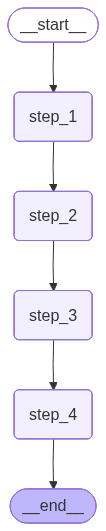

In [ ]:
workflow

In [ ]:
config = {'configurable': {'thread_id': '1'}}
workflow.invoke({'input': 'start'}, config=config)

 Step 1 executed successfully!
 Step 2 executed successfully!


KeyboardInterrupt: 

In [ ]:
list(workflow.get_state_history(config=config))

[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d163-6f8c-8002-48e987154e60'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-09T16:52:25.960629+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d162-6251-8001-35341dd87973'}}, tasks=(PregelTask(id='f1228955-f928-4919-e664-48df7624b0fd', name='step_3', path=('__pregel_pull', 'step_3'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d162-6251-8001-35341dd87973'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-09T16:52:25.959884+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '

In [ ]:
[StateSnapshot(values={'input': 'start', 'step1': 'done', 'step2': 'done'}, next=('step_3',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d163-6f8c-8002-48e987154e60'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-09T16:52:25.960629+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d162-6251-8001-35341dd87973'}}, tasks=(PregelTask(id='f1228955-f928-4919-e664-48df7624b0fd', name='step_3', path=('__pregel_pull', 'step_3'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d162-6251-8001-35341dd87973'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-09T16:52:25.959884+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d160-6591-8000-ef7b06d1c504'}}, tasks=(PregelTask(id='184843ef-2aed-da1a-a3a1-bb4397308d93', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result={'step2': 'done'}),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d160-6591-8000-ef7b06d1c504'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-09T16:52:25.959147+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d15e-67b5-bfff-eda3177f1e82'}}, tasks=(PregelTask(id='b95bfde1-d5fa-d952-f976-01890e0fc5e4', name='step_1', path=('__pregel_pull', 'step_1'), error=None, interrupts=(), state=None, result={'step1': 'done', 'input': 'start'}),), interrupts=()),
 StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08d9d5-d15e-67b5-bfff-eda3177f1e82'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-09-09T16:52:25.958385+00:00', parent_config=None, tasks=(PregelTask(id='3b67a583-dfd5-43e6-5fb2-03b32f3dc9fa', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'input': 'start'}),), interrupts=())]

In [ ]:
# rerun the workflow
final_state = workflow.invoke(None, config=config)
print(final_state)

 Step 3 executed successfully!
 Step 4 executed successfully!
{'input': 'start', 'step1': 'done', 'step2': 'done', 'step3': 'done'}
